In [1365]:
import numpy as np
import pandas as pd
import os, json, re

from collections import Counter

In [1366]:
df = pd.read_csv("data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1367]:
df.shape

(891, 12)

In [1368]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [1369]:
X = df.drop("Survived", axis = 1)
y = df["Survived"]

# data cleaning

In [1370]:
X.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Age class

In [1371]:
age_df = df.copy()
age_df = age_df[age_df["Age"].notna()]

In [1372]:
def create_age_class_column(df):
    df["age_class"] = 0
    df.loc[df["Age"] < 18, "age_class"] = 1
    df.loc[(df["Age"] >= 18) & (df["Age"] < 30), "age_class"] = 2
    df.loc[(df["Age"] >= 30) & (df["Age"] < 50), "age_class"] = 3
    df.loc[df["Age"] >= 50, "age_class"] = 4
    return df

In [1373]:
age_df = create_age_class_column(age_df)

In [1374]:
age_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,3
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,2
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,2
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,2


In [1375]:
fare_lookup = age_df.groupby(["Pclass", "age_class"])["Fare"].mean().to_dict()

In [1376]:
def predict_age_class(row, fare_lookup):
    if pd.notna(row["Age"]):
        # If age exists, calculate age_class normally
        if row["Age"] < 18:
            return 1
        elif row["Age"] < 30:
            return 2
        elif row["Age"] < 50:
            return 3
        else:
            return 4
    else:
        # If age is missing, find closest fare match within same Pclass
        pclass = row["Pclass"]
        fare = row["Fare"]
        
        # Get all fare values for this Pclass
        pclass_fares = {k: v for k, v in fare_lookup.items() if k[0] == pclass}
        
        if not pclass_fares:
            return 2  # Default to adult if no matches
            
        # Find the age_class with fare closest to this row's fare
        closest_age_class = min(pclass_fares.keys(), 
                               key=lambda x: abs(pclass_fares[x] - fare))[1]
        return closest_age_class

In [1377]:
df_with_predicted_age_class = df.copy()
df_with_predicted_age_class["age_class"] = df_with_predicted_age_class.apply(
    lambda row: predict_age_class(row, fare_lookup), axis=1
)

In [1378]:
df_with_predicted_age_class

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,2
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,2


# Actual age

In [1379]:
df_with_predicted_age_class.groupby(["Pclass", "age_class"])["Age"].mean()

Pclass  age_class
1       1            12.160000
        2            23.511628
        3            39.132184
        4            57.954545
2       1             6.623043
        2            24.092308
        3            36.265152
        4            55.631579
3       1             9.274615
        2            23.088957
        3            36.766990
        4            59.181818
Name: Age, dtype: float64

In [1380]:
age_lookup_df = df_with_predicted_age_class[df_with_predicted_age_class["Age"].notna()]\
    .groupby(["Pclass", "age_class"])["Age"].mean().reset_index()
age_lookup_df.columns = ["Pclass", "age_class", "predicted_age"]


df_age = df_with_predicted_age_class.merge(age_lookup_df, on=["Pclass", "age_class"], how="left")
df_age["Age"] = df_age["Age"].fillna(df_age["predicted_age"])
df_age = df_age.drop("predicted_age", axis=1)

# name column for dependent passenger

In [1381]:
# married
partner_list = list(df[df["Name"].str.contains("Mrs")]["Name"].str.split(","))
last_name_list = [name[0] for name in partner_list]
len(last_name_list)


129

In [1382]:
w_partner_child_list = []
for name in last_name_list:
    if len(df[df["Name"].str.contains(name)]) > 1:
        w_partner_child_list.append(name)
        
len(w_partner_child_list)

86

In [1383]:
df_partner = df_age.copy()

In [1384]:
df_partner["lastname"] = df_partner["Name"].str.split(",").str[0]

In [1385]:
# Get last names that appear more than once (indicating family groups)
family_lastnames = df_partner.groupby("lastname").size()
family_lastnames = family_lastnames[family_lastnames > 1].index

# Filter for people whose last names appear in family groups
family_only_df = df_partner[df_partner["lastname"].isin(family_lastnames)]

In [1386]:
family_only_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class,lastname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,2,Braund
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,3,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,3,Allen
5,6,0,3,"Moran, Mr. James",male,59.181818,0,0,330877,8.4583,NaN,Q,4,Moran
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S,1,Palsson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.000000,0,0,7534,9.8458,NaN,S,2,Gustafsson
877,878,0,3,"Petroff, Mr. Nedelio",male,19.000000,0,0,349212,7.8958,NaN,S,2,Petroff
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.000000,0,5,382652,29.1250,NaN,Q,3,Rice
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,2,Graham


In [1387]:
family_only_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          267
Embarked         0
age_class        0
lastname         0
dtype: int64

In [1388]:
family_only_df.sort_values(by="lastname")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class,lastname
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.00000,1,1,C.A. 2673,20.2500,NaN,S,3,Abbott
746,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.00000,1,1,C.A. 2673,20.2500,NaN,S,1,Abbott
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.00000,1,0,P/PP 3381,24.0000,NaN,C,2,Abelson
308,309,0,2,"Abelson, Mr. Samuel",male,30.00000,1,0,P/PP 3381,24.0000,NaN,C,3,Abelson
210,211,0,3,"Ali, Mr. Ahmed",male,24.00000,0,0,SOTON/O.Q. 3101311,7.0500,NaN,S,2,Ali
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,736,0,3,"Williams, Mr. Leslie",male,28.50000,0,0,54636,16.1000,NaN,S,2,Williams
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.00000,1,0,2659,14.4542,NaN,C,1,Yasbeck
620,621,0,3,"Yasbeck, Mr. Antoni",male,27.00000,1,0,2659,14.4542,NaN,C,2,Yasbeck
111,112,0,3,"Zabour, Miss. Hileni",female,14.50000,1,0,2665,14.4542,NaN,C,1,Zabour


In [1389]:
def check_family_hirerarchy(row):
    dependent_counter = 0
    dependent_threshold_lower = 18
    dependent_threshold_upper = 45
    temp_dependent = df[(df["Name"].str.contains(row["lastname"])) & (df["PassengerId"] != row["PassengerId"])]
    temp_dependent_age = list(temp_dependent["Age"])
    
    for age in temp_dependent_age:
        if age < dependent_threshold_lower or age > dependent_threshold_upper:
            dependent_counter += 1
    # if row["lastname"] == "Andersson":
    #     print(temp_dependent_age)
    #     print(f"Dependent count for {row['lastname']}: {dependent_counter}")
    adult_counter = len(temp_dependent_age) - dependent_counter
    
    if row["Age"] < dependent_threshold_lower or row["Age"] > dependent_threshold_upper:
        return 0, adult_counter
    
    return dependent_counter, adult_counter

In [1390]:
result = family_only_df.apply(lambda row: check_family_hirerarchy(row), axis=1)
family_only_df["dependent_count"], family_only_df["adult_count"] = zip(*result)

/tmp/ipykernel_2448039/1744940817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_only_df["dependent_count"], family_only_df["adult_count"] = zip(*result)
/tmp/ipykernel_2448039/1744940817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  family_only_df["dependent_count"], family_only_df["adult_count"] = zip(*result)


In [1391]:
# Abbott
family_only_df[family_only_df["lastname"] == "Andersson"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class,lastname,dependent_count,adult_count
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,3,Andersson,6,2
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,1,Andersson,0,3
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,1,Andersson,0,3
146,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S,2,Andersson,6,2
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S,1,Andersson,0,3
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S,1,Andersson,0,3
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,3,Andersson,6,2
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,1,Andersson,0,3
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S,1,Andersson,0,3


In [1392]:
result = df_partner.apply(lambda row: check_family_hirerarchy(row), axis=1)
df_partner["dependent_count"], df_partner["adult_count"] = zip(*result)

In [1393]:
df_partner.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class,lastname,dependent_count,adult_count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,Braund,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3,Cumings,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2,Heikkinen,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3,Futrelle,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3,Allen,0,1


# delete name

In [1394]:
df_partner = df_partner.drop(["Name", "lastname"], axis=1)

# gender to numeric

In [1395]:
df_gender = df_partner.copy()

In [1396]:
df_gender["Sex"] = df_gender["Sex"].map({'male': 1, "female": 0})
df_gender.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class,dependent_count,adult_count
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,1
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,C85,C,3,0,0
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2,0,0
3,4,1,1,0,35.0,1,0,113803,53.1000,C123,S,3,0,1
4,5,0,3,1,35.0,0,0,373450,8.0500,NaN,S,3,0,1


In [1397]:
df_gender.isna().sum()

PassengerId          0
Survived             0
Pclass               0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             2
age_class            0
dependent_count      0
adult_count          0
dtype: int64

## embarked column to numeric

In [1398]:
df_embarked = df_gender.copy()

In [1399]:
df_embarked["Embarked"] = df_embarked["Embarked"].map({"S": 3, "Q": 1, "C": 2})

In [1400]:
df_embarked.groupby(["Pclass", "Embarked"])["PassengerId"].count()

Pclass  Embarked
1       1.0           2
        2.0          85
        3.0         127
2       1.0           3
        2.0          17
        3.0         164
3       1.0          72
        2.0          66
        3.0         353
Name: PassengerId, dtype: int64

In [1401]:
df_embarked[df_embarked["Embarked"].isna()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class,dependent_count,adult_count
61,62,1,1,0,38.0,0,0,113572,80.0,B28,NaN,3,0,0
829,830,1,1,0,62.0,0,0,113572,80.0,B28,NaN,4,0,1


In [1402]:
df_embarked[df_embarked["Ticket"].str.contains("1135")]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class,dependent_count,adult_count
54,55,0,1,1,65.000000,0,1,113509,61.9792,B30,2.0,4,0,0
61,62,1,1,0,38.000000,0,0,113572,80.0000,B28,NaN,3,0,0
166,167,1,1,0,57.954545,0,1,113505,55.0000,E33,3.0,4,0,0
252,253,0,1,1,62.000000,0,0,113514,26.5500,C87,3.0,4,0,0
351,352,0,1,1,57.954545,0,0,113510,35.0000,C128,3.0,4,0,0
356,357,1,1,0,22.000000,0,1,113505,55.0000,E33,3.0,2,0,1
377,378,0,1,1,27.000000,0,2,113503,211.5000,C82,2.0,2,0,0
782,783,0,1,1,29.000000,0,0,113501,30.0000,D6,3.0,2,0,2
829,830,1,1,0,62.000000,0,0,113572,80.0000,B28,NaN,4,0,1


In [1403]:
df_embarked.loc[df_embarked["Embarked"].isna(), "Embarked"] = 3

In [1404]:
df_embarked.isna().sum()

PassengerId          0
Survived             0
Pclass               0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             0
age_class            0
dependent_count      0
adult_count          0
dtype: int64

# family member

In [1405]:
df_family = df_embarked.copy()
df_family["family_members"] = df_family["SibSp"] + df_family["Parch"]

# ticket

In [1406]:
df_ticket = df_family.copy()

In [1407]:
df_ticket.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class,dependent_count,adult_count,family_members
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,3.0,2,0,1,1
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,C85,2.0,3,0,0,1
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,3.0,2,0,0,0
3,4,1,1,0,35.0,1,0,113803,53.1000,C123,3.0,3,0,1,1
4,5,0,3,1,35.0,0,0,373450,8.0500,NaN,3.0,3,0,1,0


In [1408]:
# df_ticket["ticket_prefix"] = df_ticket["Ticket"].str.split(" ")[0]
# df_ticket["ticket_no"] = df_ticket["Ticket"].str.split(" ").str[1]

def get_ticket_analysis(row):
    ticket = row["Ticket"]
    if len(ticket.split(" ")) > 1:
        ticket_prefix = ticket.split(" ")[0]
        ticket_no = ticket.split(" ")[1]
    else:
        ticket_prefix = ""
        ticket_no = ticket
    return ticket_prefix, ticket_no

In [1409]:
results = df_ticket.apply(get_ticket_analysis, axis=1)
df_ticket["ticket_prefix"], df_ticket["ticket_no"] = zip(*results)

In [1410]:
share_lookup = df_ticket["ticket_no"].value_counts().to_dict()
shared_tickets_list = [k for k, v in share_lookup.items() if v > 1]

In [1411]:
def is_shared(row, shared_tickets_list):
    if row["ticket_no"] in shared_tickets_list:
        return 1
    return 0

In [1412]:
df_ticket["is_shared"] = df_ticket.apply(
    lambda row: is_shared(row, shared_tickets_list), axis=1
)

In [1413]:
df_ticket

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class,dependent_count,adult_count,family_members,ticket_prefix,ticket_no,is_shared
0,1,0,3,1,22.000000,1,0,A/5 21171,7.2500,NaN,3.0,2,0,1,1,A/5,21171,0
1,2,1,1,0,38.000000,1,0,PC 17599,71.2833,C85,2.0,3,0,0,1,PC,17599,0
2,3,1,3,0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,3.0,2,0,0,0,STON/O2.,3101282,0
3,4,1,1,0,35.000000,1,0,113803,53.1000,C123,3.0,3,0,1,1,,113803,1
4,5,0,3,1,35.000000,0,0,373450,8.0500,NaN,3.0,3,0,1,0,,373450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.000000,0,0,211536,13.0000,NaN,3.0,2,0,0,0,,211536,0
887,888,1,1,0,19.000000,0,0,112053,30.0000,B42,3.0,2,1,1,0,,112053,0
888,889,0,3,0,9.274615,1,2,W./C. 6607,23.4500,NaN,3.0,1,0,1,3,W./C.,6607,1
889,890,1,1,1,26.000000,0,0,111369,30.0000,C148,2.0,2,0,0,0,,111369,0


In [1414]:
df_ticket["ticket_prefix"] = pd.Categorical(df_ticket["ticket_prefix"]).codes

In [1415]:
df_ticket.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_class,dependent_count,adult_count,family_members,ticket_prefix,ticket_no,is_shared
0,1,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,3.0,2,0,1,1,5,21171,0
1,2,1,1,0,38.0,1,0,PC 17599,71.2833,C85,2.0,3,0,0,1,18,17599,0
2,3,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,3.0,2,0,0,0,37,3101282,0
3,4,1,1,0,35.0,1,0,113803,53.1000,C123,3.0,3,0,1,1,0,113803,1
4,5,0,3,1,35.0,0,0,373450,8.0500,NaN,3.0,3,0,1,0,0,373450,0


In [1416]:
df_ticket.drop(["Ticket"], axis=1, inplace=True)

In [1417]:
# df_ticket["ticket_no"] = df["Ticket"].str.split(" ").str[-1]

In [1418]:
# shared with how many
cabin_share_count = df_ticket["ticket_no"].value_counts().to_dict()

In [1419]:
df_ticket["total_occupants"] = df_ticket["ticket_no"].map(cabin_share_count)

In [1420]:
# shared with adult
def cabin_shared_with_adult(row):
    if row["is_shared"] == 1:
        ticket_no = row["ticket_no"]
        shared_passengers = df_ticket[df_ticket["ticket_no"] == ticket_no]
        shared_passengers_age = shared_passengers["Age"].to_list()
        return sum(1 for age in shared_passengers_age if age >= 18)
    return 0

In [1421]:
df_ticket["adult_share_count"] = df_ticket.apply(
    lambda row: cabin_shared_with_adult(row), axis=1
) # number of adults sharing the same ticket

In [1422]:
df_ticket

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,age_class,dependent_count,adult_count,family_members,ticket_prefix,ticket_no,is_shared,total_occupants,adult_share_count
0,1,0,3,1,22.000000,1,0,7.2500,NaN,3.0,2,0,1,1,5,21171,0,1,0
1,2,1,1,0,38.000000,1,0,71.2833,C85,2.0,3,0,0,1,18,17599,0,1,0
2,3,1,3,0,26.000000,0,0,7.9250,NaN,3.0,2,0,0,0,37,3101282,0,1,0
3,4,1,1,0,35.000000,1,0,53.1000,C123,3.0,3,0,1,1,0,113803,1,2,2
4,5,0,3,1,35.000000,0,0,8.0500,NaN,3.0,3,0,1,0,0,373450,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.000000,0,0,13.0000,NaN,3.0,2,0,0,0,0,211536,0,1,0
887,888,1,1,0,19.000000,0,0,30.0000,B42,3.0,2,1,1,0,0,112053,0,1,0
888,889,0,3,0,9.274615,1,2,23.4500,NaN,3.0,1,0,1,3,39,6607,1,2,0
889,890,1,1,1,26.000000,0,0,30.0000,C148,2.0,2,0,0,0,0,111369,0,1,0


# Cabin analysis

In [1423]:
def process_cabin(c: str) -> tuple:
    if pd.isna(c):
        return None, None
    
    match = re.match(r"([A-Z])(\d+)$", c) # c29
    if match:
        alphabet_part = match.group(1)
        numeric_part = match.group(2)
        return alphabet_part, int(numeric_part) # c29 = c, 29
    
    else:
        if re.match(r"[A-Z]$", c): # single letter, C
            return c, 0
        
        else:
            if len(c.split(" ")) > 1: # C23 C25 C27 or F G29
                temp_cabin_class = []
                temp_cabin_number = []
                for sp in c.split(" "):
                    sp.strip()
                    cabin_class, cabin_number = process_cabin(sp)
                    temp_cabin_class.append(cabin_class)
                    temp_cabin_number.append(cabin_number)
                a_set = set(temp_cabin_class)
                # print(a_set)
                if len(a_set) == 1:
                    return a_set.pop(), int(np.median(temp_cabin_number))
                else:
                    return "z", temp_cabin_number[-1] # F G29

In [1424]:
# print(process_cabin("F E34"))
# print(process_cabin("C23 C25 C27"))
# print(process_cabin("C"))
# print(process_cabin("C123"))

In [1425]:
# X["Cabin"].isna().sum(), X.shape

In [1426]:
# X["Pclass"].value_counts()

In [1427]:
# cabin_analysis_df = X.dropna(subset=["Cabin"]).copy()
# cabin_analysis_df.shape

In [1428]:
# cabin_setup = {}
# for i in range(1, 4): #pclass
#     all_cabin_classes = []
#     pclass_df = cabin_analysis_df[cabin_analysis_df["Pclass"] == i]
#     # cabins = pclass_df["Cabin"].value_counts().keys()
#     pclass_cabins = pclass_df["Cabin"]
#     # print(cabins)
#     for cabin in pclass_cabins:
#         cabin_class, _ = process_cabin(cabin)
#         all_cabin_classes.append(cabin_class)
        
#     cabin_setup[i] = Counter(all_cabin_classes)

In [1429]:
# cabin_setup

In [1430]:
# all_c_c = []
# for val in cabin_analysis_df["Cabin"]:
#     c_c, _ = process_cabin(val)
#     all_c_c.append(c_c)
# cabin_analysis_df["cabin_class"] = all_c_c

In [1431]:
# cabin_analysis_df.head()

In [1432]:
# cabin_analysis_df.groupby(["Pclass", "cabin_class"])["Fare"].mean()

In [1433]:
# [_ for _ in cabin_analysis_df["Cabin"] if len(_.split(" "))>1]

In [1434]:
df_cabin = df_ticket.copy()

In [1435]:
def fill_missing_cabin_class(df, fare_col='Fare', pclass_col='Pclass', cabin_class_col='cabin_class'):
    """
    Fill missing cabin class values based on fare and pclass similarity to known patterns.
    """
    df_filled = df.copy()
    
    # Calculate mean fare for each pclass-cabin_class combination
    fare_means = df.groupby([pclass_col, cabin_class_col])[fare_col].mean()
    
    # Find rows with missing cabin class
    missing_mask = df[cabin_class_col].isna()
    
    # For each missing row, find the best match
    for idx in df[missing_mask].index:
        passenger_fare = df.loc[idx, fare_col]
        passenger_pclass = df.loc[idx, pclass_col]
        
        # Get all cabin classes for this pclass
        try:
            available_classes = fare_means[passenger_pclass].index
            
            # Calculate absolute difference between passenger fare and mean fare for each cabin class
            fare_differences = {}
            for cabin_class in available_classes:
                mean_fare = fare_means[passenger_pclass][cabin_class]
                fare_differences[cabin_class] = abs(passenger_fare - mean_fare)
            
            # Find cabin class with smallest fare difference
            if fare_differences:
                best_match = min(fare_differences, key=fare_differences.get)
                df_filled.loc[idx, cabin_class_col] = best_match
            
        except KeyError:
            # No data for this pclass, skip or assign default
            continue
    
    return df_filled

In [1436]:
df_cabin['cabin_class'] = df_cabin['Cabin'].apply(process_cabin).apply(lambda x: x[0] if x is not None else None)

In [1437]:
df_cabin

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,age_class,dependent_count,adult_count,family_members,ticket_prefix,ticket_no,is_shared,total_occupants,adult_share_count,cabin_class
0,1,0,3,1,22.000000,1,0,7.2500,NaN,3.0,2,0,1,1,5,21171,0,1,0,None
1,2,1,1,0,38.000000,1,0,71.2833,C85,2.0,3,0,0,1,18,17599,0,1,0,C
2,3,1,3,0,26.000000,0,0,7.9250,NaN,3.0,2,0,0,0,37,3101282,0,1,0,None
3,4,1,1,0,35.000000,1,0,53.1000,C123,3.0,3,0,1,1,0,113803,1,2,2,C
4,5,0,3,1,35.000000,0,0,8.0500,NaN,3.0,3,0,1,0,0,373450,0,1,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.000000,0,0,13.0000,NaN,3.0,2,0,0,0,0,211536,0,1,0,None
887,888,1,1,0,19.000000,0,0,30.0000,B42,3.0,2,1,1,0,0,112053,0,1,0,B
888,889,0,3,0,9.274615,1,2,23.4500,NaN,3.0,1,0,1,3,39,6607,1,2,0,None
889,890,1,1,1,26.000000,0,0,30.0000,C148,2.0,2,0,0,0,0,111369,0,1,0,C


In [1438]:
df_cabin = fill_missing_cabin_class(df_cabin)
df_cabin

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,age_class,dependent_count,adult_count,family_members,ticket_prefix,ticket_no,is_shared,total_occupants,adult_share_count,cabin_class
0,1,0,3,1,22.000000,1,0,7.2500,NaN,3.0,2,0,1,1,5,21171,0,1,0,F
1,2,1,1,0,38.000000,1,0,71.2833,C85,2.0,3,0,0,1,18,17599,0,1,0,C
2,3,1,3,0,26.000000,0,0,7.9250,NaN,3.0,2,0,0,0,37,3101282,0,1,0,F
3,4,1,1,0,35.000000,1,0,53.1000,C123,3.0,3,0,1,1,0,113803,1,2,2,C
4,5,0,3,1,35.000000,0,0,8.0500,NaN,3.0,3,0,1,0,0,373450,0,1,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.000000,0,0,13.0000,NaN,3.0,2,0,0,0,0,211536,0,1,0,D
887,888,1,1,0,19.000000,0,0,30.0000,B42,3.0,2,1,1,0,0,112053,0,1,0,B
888,889,0,3,0,9.274615,1,2,23.4500,NaN,3.0,1,0,1,3,39,6607,1,2,0,G
889,890,1,1,1,26.000000,0,0,30.0000,C148,2.0,2,0,0,0,0,111369,0,1,0,C


# cabin number

In [1439]:
df_cabin["cabin_number"] = df_cabin["Cabin"]\
    .apply(process_cabin)\
        .apply(lambda x: x[1] if x is not None else None)

In [1440]:
df_cabin

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,...,dependent_count,adult_count,family_members,ticket_prefix,ticket_no,is_shared,total_occupants,adult_share_count,cabin_class,cabin_number
0,1,0,3,1,22.000000,1,0,7.2500,NaN,3.0,...,0,1,1,5,21171,0,1,0,F,NaN
1,2,1,1,0,38.000000,1,0,71.2833,C85,2.0,...,0,0,1,18,17599,0,1,0,C,85.0
2,3,1,3,0,26.000000,0,0,7.9250,NaN,3.0,...,0,0,0,37,3101282,0,1,0,F,NaN
3,4,1,1,0,35.000000,1,0,53.1000,C123,3.0,...,0,1,1,0,113803,1,2,2,C,123.0
4,5,0,3,1,35.000000,0,0,8.0500,NaN,3.0,...,0,1,0,0,373450,0,1,0,F,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.000000,0,0,13.0000,NaN,3.0,...,0,0,0,0,211536,0,1,0,D,NaN
887,888,1,1,0,19.000000,0,0,30.0000,B42,3.0,...,1,1,0,0,112053,0,1,0,B,42.0
888,889,0,3,0,9.274615,1,2,23.4500,NaN,3.0,...,0,1,3,39,6607,1,2,0,G,NaN
889,890,1,1,1,26.000000,0,0,30.0000,C148,2.0,...,0,0,0,0,111369,0,1,0,C,148.0


In [1441]:
# sharing in pclass 1
target = df_cabin[df_cabin["Pclass"] == 1]
target_dict_count = target["cabin_number"].value_counts()
target_list = list(target_dict_count.to_dict().values())
len([x for x in target_list if x > 1])

50

In [1442]:
# with siblings or parents in pclass 1
df_cabin[(df_cabin["Pclass"] == 1) & ((df_cabin["SibSp"] > 0) | (df_cabin["Parch"] > 0))].shape

(107, 21)

In [1443]:
# df_cabin["cabin_number"] = df_cabin["Cabin"].apply(process_cabin).apply(lambda x: x[1] if x is not None else None)

In [1444]:
import random

def assign_missing_cabins_by_pclass_range(df, pclass_col='Pclass', cabin_col='cabin_number'):
    """
    Assign missing cabin numbers randomly within each Pclass's existing range.
    Only fills NaN values, leaves existing values unchanged.
    """
    df_filled = df.copy()
    
    # Get cabin number ranges for each Pclass (only non-NaN values)
    pclass_ranges = {}
    
    for pclass in df[pclass_col].unique():
        # Get existing cabin numbers for this Pclass (excluding NaN)
        pclass_cabins = df[(df[pclass_col] == pclass) & (df[cabin_col].notna())][cabin_col]
        
        if len(pclass_cabins) > 0:
            # Since cabin_number is float64, directly get min/max
            pclass_ranges[pclass] = (int(pclass_cabins.min()), int(pclass_cabins.max()))
    
    print("Cabin ranges by Pclass:")
    for pclass, (min_cabin, max_cabin) in pclass_ranges.items():
        print(f"Pclass {pclass}: {min_cabin} - {max_cabin}")
    
    # Assign missing values only
    for pclass in pclass_ranges.keys():
        # Get rows with missing cabin numbers for this Pclass
        missing_mask = (df_filled[pclass_col] == pclass) & (df_filled[cabin_col].isna())
        missing_indices = df_filled[missing_mask].index
        
        if len(missing_indices) > 0:
            min_cabin, max_cabin = pclass_ranges[pclass]
            
            # Generate random cabin numbers within range
            random_cabins = [float(random.randint(min_cabin, max_cabin)) for _ in range(len(missing_indices))]
            
            # Assign the random cabin numbers (keep as float to match dtype)
            df_filled.loc[missing_indices, cabin_col] = random_cabins
            
            print(f"Assigned {len(missing_indices)} missing cabins for Pclass {pclass}")
    
    return df_filled

In [1445]:

df_cabin_no = assign_missing_cabins_by_pclass_range(df_cabin)

Cabin ranges by Pclass:
Pclass 3: 6 - 121
Pclass 1: 0 - 148
Pclass 2: 0 - 101
Assigned 479 missing cabins for Pclass 3
Assigned 40 missing cabins for Pclass 1
Assigned 168 missing cabins for Pclass 2


In [1446]:
df_cabin_no.drop("Cabin", axis=1, inplace=True)

In [1447]:
df_cabin_no.isna().sum()

PassengerId          0
Survived             0
Pclass               0
Sex                  0
Age                  0
SibSp                0
Parch                0
Fare                 0
Embarked             0
age_class            0
dependent_count      0
adult_count          0
family_members       0
ticket_prefix        0
ticket_no            0
is_shared            0
total_occupants      0
adult_share_count    0
cabin_class          0
cabin_number         0
dtype: int64

In [1448]:
df_cabin_no['cabin_class'] = pd.Categorical(df_cabin_no['cabin_class']).codes

In [1449]:
df_cabin_no.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,age_class,dependent_count,adult_count,family_members,ticket_prefix,ticket_no,is_shared,total_occupants,adult_share_count,cabin_class,cabin_number
0,1,0,3,1,22.0,1,0,7.2500,3.0,2,0,1,1,5,21171,0,1,0,5,87.0
1,2,1,1,0,38.0,1,0,71.2833,2.0,3,0,0,1,18,17599,0,1,0,2,85.0
2,3,1,3,0,26.0,0,0,7.9250,3.0,2,0,0,0,37,3101282,0,1,0,5,9.0
3,4,1,1,0,35.0,1,0,53.1000,3.0,3,0,1,1,0,113803,1,2,2,2,123.0
4,5,0,3,1,35.0,0,0,8.0500,3.0,3,0,1,0,0,373450,0,1,0,5,54.0


In [1450]:
df_cabin_no.dtypes

PassengerId            int64
Survived               int64
Pclass                 int64
Sex                    int64
Age                  float64
SibSp                  int64
Parch                  int64
Fare                 float64
Embarked             float64
age_class              int64
dependent_count        int64
adult_count            int64
family_members         int64
ticket_prefix           int8
ticket_no             object
is_shared              int64
total_occupants        int64
adult_share_count      int64
cabin_class             int8
cabin_number         float64
dtype: object

In [1451]:
df_cabin_no.drop(["ticket_no", 
                  "PassengerId", 
                  "ticket_prefix", 
                  "total_occupants", 
                  "dependent_count",
                  "family_members",
                  "adult_count",
                  "cabin_number",
                  "SibSp"], axis=1, inplace=True)

# test

In [1452]:
import numpy as np
import pandas as pd
import re
import random
from collections import Counter

def process_test_data(test_csv_path, original_train_csv_path="data/train.csv"):
    """
    Apply all training data transformations to test data
    """
    # Load test data and original training data
    test_df = pd.read_csv(test_csv_path)
    train_df = pd.read_csv(original_train_csv_path)
    
    print("Original test data shape:", test_df.shape)
    print("Missing values in test data:")
    print(test_df.isna().sum())
    
    # 1. AGE CLASS PREDICTION
    print("\n1. Processing age classes...")
    
    # Create fare lookup from training data (already computed)
    age_df_train = train_df[train_df["Age"].notna()].copy()
    
    # Create age class for training data
    def create_age_class_column(df):
        df = df.copy()
        df["age_class"] = 0
        df.loc[df["Age"] < 18, "age_class"] = 1
        df.loc[(df["Age"] >= 18) & (df["Age"] < 30), "age_class"] = 2
        df.loc[(df["Age"] >= 30) & (df["Age"] < 50), "age_class"] = 3
        df.loc[df["Age"] >= 50, "age_class"] = 4
        return df
    
    age_df_train = create_age_class_column(age_df_train)
    fare_lookup = age_df_train.groupby(["Pclass", "age_class"])["Fare"].mean().to_dict()
    
    def predict_age_class(row, fare_lookup):
        if pd.notna(row["Age"]):
            if row["Age"] < 18:
                return 1
            elif row["Age"] < 30:
                return 2
            elif row["Age"] < 50:
                return 3
            else:
                return 4
        else:
            pclass = row["Pclass"]
            fare = row["Fare"]
            
            # Handle missing fare
            if pd.isna(fare):
                return 2  # Default to young adult
            
            pclass_fares = {k: v for k, v in fare_lookup.items() if k[0] == pclass}
            
            if not pclass_fares:
                return 2
                
            closest_age_class = min(pclass_fares.keys(), 
                                   key=lambda x: abs(pclass_fares[x] - fare))[1]
            return closest_age_class
    
    test_df["age_class"] = test_df.apply(
        lambda row: predict_age_class(row, fare_lookup), axis=1
    )
    
    # 2. FILL MISSING AGES
    print("2. Filling missing ages...")
    
    # Create age lookup from training data
    train_with_age_class = train_df[train_df["Age"].notna()].copy()
    train_with_age_class["age_class"] = train_with_age_class.apply(
        lambda row: predict_age_class(row, fare_lookup), axis=1
    )
    
    age_lookup_df = train_with_age_class.groupby(["Pclass", "age_class"])["Age"].mean().reset_index()
    age_lookup_df.columns = ["Pclass", "age_class", "predicted_age"]
    
    test_df = test_df.merge(age_lookup_df, on=["Pclass", "age_class"], how="left")
    test_df["Age"] = test_df["Age"].fillna(test_df["predicted_age"])
    test_df = test_df.drop("predicted_age", axis=1)
    
    # 3. FAMILY HIERARCHY
    print("3. Processing family hierarchy...")
    
    test_df["lastname"] = test_df["Name"].str.split(",").str[0]
    
    def check_family_hierarchy_test(row, full_df):
        dependent_counter = 0
        dependent_threshold_lower = 18
        dependent_threshold_upper = 45
        
        # Use the test dataframe itself for family analysis
        temp_dependent = full_df[(full_df["Name"].str.contains(row["lastname"], na=False)) & 
                                (full_df["PassengerId"] != row["PassengerId"])]
        temp_dependent_age = list(temp_dependent["Age"])
        
        for age in temp_dependent_age:
            if age < dependent_threshold_lower or age > dependent_threshold_upper:
                dependent_counter += 1
        
        adult_counter = len(temp_dependent_age) - dependent_counter
        
        if row["Age"] < dependent_threshold_lower or row["Age"] > dependent_threshold_upper:
            return 0, adult_counter
        
        return dependent_counter, adult_counter
    
    result = test_df.apply(lambda row: check_family_hierarchy_test(row, test_df), axis=1)
    test_df["dependent_count"], test_df["adult_count"] = zip(*result)
    
    # 4. DROP NAME COLUMNS
    print("4. Dropping name columns...")
    test_df = test_df.drop(["Name", "lastname"], axis=1)
    
    # 5. GENDER TO NUMERIC
    print("5. Converting gender to numeric...")
    test_df["Sex"] = test_df["Sex"].map({'male': 1, "female": 0})
    
    # 6. EMBARKED TO NUMERIC
    print("6. Processing embarked column...")
    test_df["Embarked"] = test_df["Embarked"].map({"S": 3, "Q": 1, "C": 2})
    
    # Fill missing embarked values (use mode from training or default to 3 like in training)
    test_df["Embarked"] = test_df["Embarked"].fillna(3)
    
    # 7. FAMILY MEMBERS
    print("7. Creating family members column...")
    test_df["family_members"] = test_df["SibSp"] + test_df["Parch"]
    
    # 8. TICKET PROCESSING
    print("8. Processing tickets...")
    
    def get_ticket_analysis(row):
        ticket = row["Ticket"]
        if len(ticket.split(" ")) > 1:
            ticket_prefix = ticket.split(" ")[0]
            ticket_no = ticket.split(" ")[1]
        else:
            ticket_prefix = ""
            ticket_no = ticket
        return ticket_prefix, ticket_no
    
    results = test_df.apply(get_ticket_analysis, axis=1)
    test_df["ticket_prefix"], test_df["ticket_no"] = zip(*results)
    
    # Shared tickets analysis
    share_lookup = test_df["ticket_no"].value_counts().to_dict()
    shared_tickets_list = [k for k, v in share_lookup.items() if v > 1]
    
    def is_shared(row, shared_tickets_list):
        if row["ticket_no"] in shared_tickets_list:
            return 1
        return 0
    
    test_df["is_shared"] = test_df.apply(
        lambda row: is_shared(row, shared_tickets_list), axis=1
    )
    
    # Convert ticket prefix to numeric using consistent mapping
    # Create mapping from all unique prefixes in test data
    all_prefixes = list(test_df["ticket_prefix"].unique())
    prefix_mapping = {prefix: i for i, prefix in enumerate(sorted(all_prefixes))}
    test_df["ticket_prefix"] = test_df["ticket_prefix"].map(prefix_mapping).fillna(-1)
    
    test_df = test_df.drop(["Ticket"], axis=1)
    
    # Total occupants
    cabin_share_count = test_df["ticket_no"].value_counts().to_dict()
    test_df["total_occupants"] = test_df["ticket_no"].map(cabin_share_count)
    
    # Adult share count
    def cabin_shared_with_adult(row, full_df):
        if row["is_shared"] == 1:
            ticket_no = row["ticket_no"]
            shared_passengers = full_df[full_df["ticket_no"] == ticket_no]
            shared_passengers_age = shared_passengers["Age"].to_list()
            return sum(1 for age in shared_passengers_age if age >= 18)
        return 0
    
    test_df["adult_share_count"] = test_df.apply(
        lambda row: cabin_shared_with_adult(row, test_df), axis=1
    )
    
    # 9. CABIN PROCESSING
    print("9. Processing cabins...")
    
    def process_cabin(c):
        if pd.isna(c):
            return None, None
        
        match = re.match(r"([A-Z])(\d+)$", c)
        if match:
            alphabet_part = match.group(1)
            numeric_part = match.group(2)
            return alphabet_part, int(numeric_part)
        
        else:
            if re.match(r"[A-Z]$", c):
                return c, 0
            
            else:
                if len(c.split(" ")) > 1:
                    temp_cabin_class = []
                    temp_cabin_number = []
                    for sp in c.split(" "):
                        sp.strip()
                        cabin_class, cabin_number = process_cabin(sp)
                        temp_cabin_class.append(cabin_class)
                        temp_cabin_number.append(cabin_number)
                    a_set = set(temp_cabin_class)
                    if len(a_set) == 1:
                        return a_set.pop(), int(np.median(temp_cabin_number))
                    else:
                        return "z", temp_cabin_number[-1]
    
    test_df['cabin_class'] = test_df['Cabin'].apply(process_cabin).apply(lambda x: x[0] if x is not None else None)
    
    # Fill missing cabin class using training data patterns
    def fill_missing_cabin_class(df, train_df_with_cabins):
        df_filled = df.copy()
        
        # Use training data to create fare-cabin class mapping
        fare_means = train_df_with_cabins.groupby(['Pclass', 'cabin_class'])['Fare'].mean()
        
        missing_mask = df['cabin_class'].isna()
        
        for idx in df[missing_mask].index:
            passenger_fare = df.loc[idx, 'Fare']
            passenger_pclass = df.loc[idx, 'Pclass']
            
            if pd.isna(passenger_fare):
                continue
            
            try:
                available_classes = fare_means[passenger_pclass].index
                
                fare_differences = {}
                for cabin_class in available_classes:
                    mean_fare = fare_means[passenger_pclass][cabin_class]
                    fare_differences[cabin_class] = abs(passenger_fare - mean_fare)
                
                if fare_differences:
                    best_match = min(fare_differences, key=fare_differences.get)
                    df_filled.loc[idx, 'cabin_class'] = best_match
                
            except KeyError:
                continue
        
        return df_filled
    
    # Create training cabin class data for reference
    train_with_cabin_class = train_df.copy()
    train_with_cabin_class['cabin_class'] = train_with_cabin_class['Cabin'].apply(process_cabin).apply(lambda x: x[0] if x is not None else None)
    train_cabin_data = train_with_cabin_class[train_with_cabin_class['cabin_class'].notna()]
    
    test_df = fill_missing_cabin_class(test_df, train_cabin_data)
    
    # 10. CABIN NUMBER
    print("10. Processing cabin numbers...")
    
    test_df["cabin_number"] = test_df["Cabin"].apply(process_cabin).apply(lambda x: x[1] if x is not None else None)
    
    # Fill missing cabin numbers using training data ranges
    def assign_missing_cabins_by_pclass_range(df, train_df_with_cabins):
        df_filled = df.copy()
        
        # Get cabin ranges from training data
        pclass_ranges = {}
        for pclass in train_df_with_cabins['Pclass'].unique():
            pclass_cabins = train_df_with_cabins[
                (train_df_with_cabins['Pclass'] == pclass) & 
                (train_df_with_cabins['cabin_number'].notna())
            ]['cabin_number']
            
            if len(pclass_cabins) > 0:
                pclass_ranges[pclass] = (int(pclass_cabins.min()), int(pclass_cabins.max()))
        
        # Fill missing values
        for pclass in pclass_ranges.keys():
            missing_mask = (df_filled['Pclass'] == pclass) & (df_filled['cabin_number'].isna())
            missing_indices = df_filled[missing_mask].index
            
            if len(missing_indices) > 0:
                min_cabin, max_cabin = pclass_ranges[pclass]
                random_cabins = [float(random.randint(min_cabin, max_cabin)) for _ in range(len(missing_indices))]
                df_filled.loc[missing_indices, 'cabin_number'] = random_cabins
        
        return df_filled
    
    # Create training cabin number data
    train_with_cabin_number = train_df.copy()
    train_with_cabin_number['cabin_number'] = train_with_cabin_number['Cabin'].apply(process_cabin).apply(lambda x: x[1] if x is not None else None)
    
    test_df = assign_missing_cabins_by_pclass_range(test_df, train_with_cabin_number)
    
    # 11. FINAL CLEANUP
    print("11. Final cleanup...")
    
    test_df = test_df.drop("Cabin", axis=1)
    
    # Convert cabin_class to numeric codes
    # Use training data to get consistent encoding
    train_cabin_classes = sorted(train_with_cabin_class['cabin_class'].dropna().unique())
    cabin_class_mapping = {cls: i for i, cls in enumerate(train_cabin_classes)}
    test_df['cabin_class'] = test_df['cabin_class'].map(cabin_class_mapping).fillna(-1)
    
    test_df = test_df.drop(["ticket_no", 
                  "PassengerId", 
                  "ticket_prefix", 
                  "total_occupants", 
                  "dependent_count",
                  "family_members",
                  "adult_count",
                  "cabin_number",
                  "SibSp"], axis=1)
    
    print("\nFinal test data shape:", test_df.shape)
    print("Missing values in processed test data:")
    print(test_df.isna().sum())
    
    return test_df

# Usage:
# processed_test_df = process_test_data("data/test.csv")  # Uses original train.csv by default
# OR specify custom training data path:
# processed_test_df = process_test_data("data/test.csv", "data/train.csv")

In [1453]:
test_df = process_test_data("data/test.csv")

Original test data shape: (418, 11)
Missing values in test data:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

1. Processing age classes...
2. Filling missing ages...
3. Processing family hierarchy...
4. Dropping name columns...
5. Converting gender to numeric...
6. Processing embarked column...
7. Creating family members column...
8. Processing tickets...
9. Processing cabins...
10. Processing cabin numbers...
11. Final cleanup...

Final test data shape: (418, 10)
Missing values in processed test data:
Pclass               0
Sex                  0
Age                  0
Parch                0
Fare                 1
Embarked             0
age_class            0
is_shared            0
adult_share_count    0
cabin_class          0
dtype: int64


In [1454]:
# test_df = test_df.copy()
# test_df["Fare"] = test_df["Fare"].fillna(
#     test_df.groupby(["Pclass", "cabin_class"])["Fare"].transform("mean")
# )
test_df["Fare"] = test_df["Fare"].fillna(
    test_df.groupby(["Pclass", "cabin_class"])["Fare"].transform("mean")
)

# Then fill any remaining NaN with overall fare mean
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].mean())

In [1455]:
test_df.isna().sum()

Pclass               0
Sex                  0
Age                  0
Parch                0
Fare                 0
Embarked             0
age_class            0
is_shared            0
adult_share_count    0
cabin_class          0
dtype: int64

# training

In [1456]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# categorical_cols = df_with_cabins.select_dtypes(include=['object']).columns
# for col in categorical_cols:
#     if col != 'target': 
#         le = LabelEncoder()
#         df[col] = le.fit_transform(df[col])


# # Scale features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_with_cabins)

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y, test_size=0.2, random_state=42, stratify=y
# )

# # Train model
# log_reg = LogisticRegression(random_state=42, max_iter=1000)
# log_reg.fit(X_train, y_train)

# # Cross-validation
# cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5)
# print(f"Cross-validation scores: {cv_scores}")
# print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

In [1457]:
X = df_cabin_no.drop("Survived", axis=1)
y = df_cabin_no["Survived"]

In [1458]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import pandas as pd

# # Prepare training data
# categorical_cols = df_with_cabins.select_dtypes(include=['object']).columns
# for col in categorical_cols:
#     if col != 'target': 
#         le = LabelEncoder()
#         df_with_cabins[col] = le.fit_transform(df_with_cabins[col])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# # Apply same scaling to test data (assuming X_test_final is your preprocessed test data)
X_test_scaled = scaler.transform(test_df)

print("Training models on full dataset and generating submissions...")
print("="*60)
df_test = pd.read_csv("data/test.csv")

# 1. Logistic Regression
# print("1. Training Logistic Regression...")
# log_reg = LogisticRegression(random_state=42, max_iter=1000)
# log_reg.fit(X_scaled, y)

# submission_lr = pd.DataFrame({
#     'PassengerId': df_test['PassengerId'],
#     'Survived': log_reg.predict(X_test_scaled)
# })
# submission_lr.to_csv('submission_logistic.csv', index=False)
# print("   ✓ submission_logistic.csv created")

# 2. Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=7)
rf.fit(X_scaled, y)

submission_rf = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': rf.predict(X_test_scaled)
})
submission_rf.to_csv('output/submission_random_forest.csv', index=False)
print("   ✓ submission_random_forest.csv created")

# 3. XGBoost
# print("3. Training XGBoost...")
# xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, max_depth=4)
# xgb_model.fit(X_scaled, y)

# submission_xgb = pd.DataFrame({
#     'PassengerId': df_test['PassengerId'],
#     'Survived': xgb_model.predict(X_test_scaled)
# })
# submission_xgb.to_csv('submission_xgboost.csv', index=False)
# print("   ✓ submission_xgboost.csv created")

# # 4. Gradient Boosting
# print("4. Training Gradient Boosting...")
# gb = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=4)
# gb.fit(X_scaled, y)

# submission_gb = pd.DataFrame({
#     'PassengerId': df_test['PassengerId'],
#     'Survived': gb.predict(X_test_scaled)
# })
# submission_gb.to_csv('submission_gradient_boosting.csv', index=False)
# print("   ✓ submission_gradient_boosting.csv created")

# 5. Support Vector Machine
print("Training SVM...")
svm = SVC(kernel='rbf', random_state=42, probability=True)
svm.fit(X_scaled, y)

submission_svm = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': svm.predict(X_test_scaled)
})
submission_svm.to_csv('output/submission_svm.csv', index=False)
print("   ✓ submission_svm.csv created")

# # 6. K-Nearest Neighbors
# print("6. Training KNN...")
# knn = KNeighborsClassifier(n_neighbors=7)
# knn.fit(X_scaled, y)

# submission_knn = pd.DataFrame({
#     'PassengerId': df_test['PassengerId'],
#     'Survived': knn.predict(X_test_scaled)
# })
# submission_knn.to_csv('submission_knn.csv', index=False)
# print("   ✓ submission_knn.csv created")

# # 7. Naive Bayes
# print("7. Training Naive Bayes...")
# nb = GaussianNB()
# nb.fit(X_scaled, y)

# submission_nb = pd.DataFrame({
#     'PassengerId': df_test['PassengerId'],
#     'Survived': nb.predict(X_test_scaled)
# })
# submission_nb.to_csv('submission_naive_bayes.csv', index=False)
# print("   ✓ submission_naive_bayes.csv created")

# 8. Voting Ensemble
print("Training Voting Ensemble...")
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        # ('xgb', xgb_model),
        # ('gb', gb),
        ('svm', svm)
    ],
    voting='soft'
)
voting_clf.fit(X_scaled, y)

submission_voting = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': voting_clf.predict(X_test_scaled)
})
submission_voting.to_csv('output/submission_voting_ensemble.csv', index=False)
print("   ✓ submission_voting_ensemble.csv created")

# 9. Random Forest with different parameters
print("9. Training Random Forest (Tuned)...")
rf_tuned = RandomForestClassifier(
    n_estimators=200, 
    max_depth=6, 
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_tuned.fit(X_scaled, y)

submission_rf_tuned = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': rf_tuned.predict(X_test_scaled)
})
submission_rf_tuned.to_csv('output/submission_rf_tuned.csv', index=False)
print("   ✓ submission_rf_tuned.csv created")

# 10. XGBoost with different parameters
# print("10. Training XGBoost (Tuned)...")
# xgb_tuned = xgb.XGBClassifier(
#     n_estimators=200,
#     max_depth=3,
#     learning_rate=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )
# xgb_tuned.fit(X_scaled, y)

# submission_xgb_tuned = pd.DataFrame({
#     'PassengerId': df_test['PassengerId'],
#     'Survived': xgb_tuned.predict(X_test_scaled)
# })
# submission_xgb_tuned.to_csv('submission_xgb_tuned.csv', index=False)
# print("   ✓ submission_xgb_tuned.csv created")

# print("\n" + "="*60)
# print("ALL SUBMISSION FILES CREATED!")
# print("="*60)
# print("Files generated:")
# print("1.  submission_logistic.csv")
# print("2.  submission_random_forest.csv")
# print("3.  submission_xgboost.csv")
# print("4.  submission_gradient_boosting.csv")
# print("5.  submission_svm.csv")
# print("6.  submission_knn.csv")
# print("7.  submission_naive_bayes.csv")
# print("8.  submission_voting_ensemble.csv")
# print("9.  submission_rf_tuned.csv")
# print("10. submission_xgb_tuned.csv")

# Check prediction distributions
print("\nPrediction distributions:")
models_preds = {
    # 'Logistic': log_reg.predict(X_test_scaled),
    'RandomForest': rf.predict(X_test_scaled),
    # 'XGBoost': xgb_model.predict(X_test_scaled),
    # 'GradientBoosting': gb.predict(X_test_scaled),
    'SVM': svm.predict(X_test_scaled),
    'VotingEnsemble': voting_clf.predict(X_test_scaled)
}

for model, preds in models_preds.items():
    survival_rate = preds.mean()
    print(f"{model:<15}: {survival_rate:.3f} survival rate")

Training models on full dataset and generating submissions...
Training Random Forest...
   ✓ submission_random_forest.csv created
Training SVM...
   ✓ submission_svm.csv created
Training Voting Ensemble...
   ✓ submission_voting_ensemble.csv created
9. Training Random Forest (Tuned)...
   ✓ submission_rf_tuned.csv created

Prediction distributions:
RandomForest   : 0.313 survival rate
SVM            : 0.337 survival rate
VotingEnsemble : 0.323 survival rate


In [1459]:
X

,Pclass,Sex,Age,Parch,Fare,Embarked,age_class,is_shared,adult_share_count,cabin_class
0,3,1,22.000000,0,7.2500,3.0,2,0,0,5
1,1,0,38.000000,0,71.2833,2.0,3,0,0,2
2,3,0,26.000000,0,7.9250,3.0,2,0,0,5
3,1,0,35.000000,0,53.1000,3.0,3,1,2,2
4,3,1,35.000000,0,8.0500,3.0,3,0,0,5
...,...,...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,13.0000,3.0,2,0,0,3
887,1,0,19.000000,0,30.0000,3.0,2,0,0,1
888,3,0,9.274615,2,23.4500,3.0,1,1,0,6
889,1,1,26.000000,0,30.0000,2.0,2,0,0,2


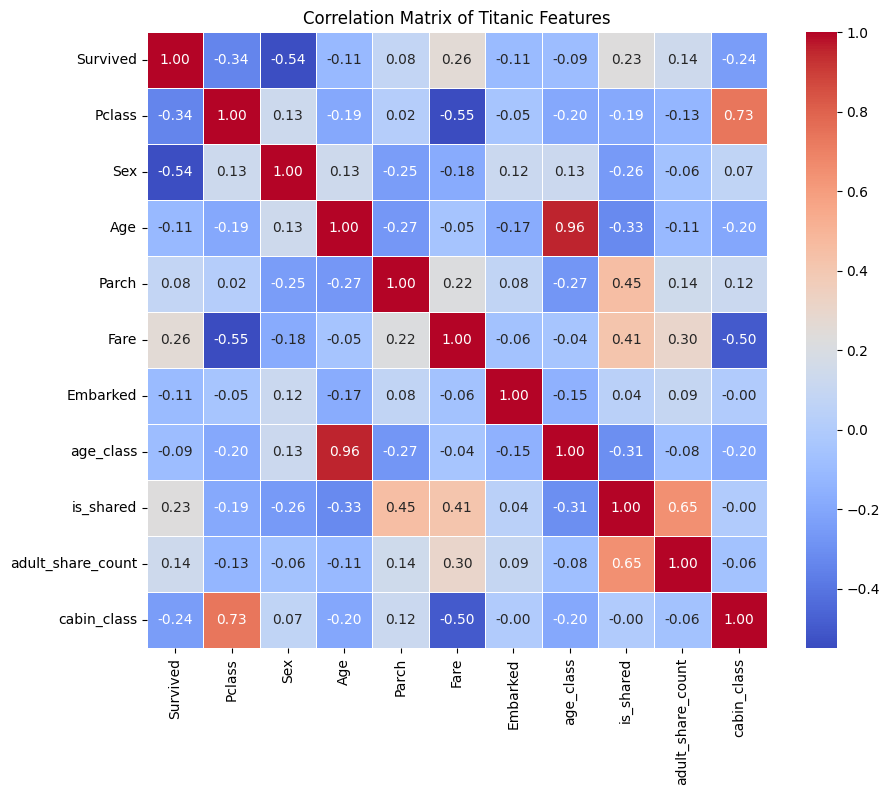

In [1460]:
import seaborn as sns
import matplotlib.pyplot as plt
 
plt.figure(figsize=(10, 8))
sns.heatmap(df_cabin_no.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Titanic Features')
plt.show()

In [1461]:
# Sort correlation values with respect to Survived
survived_corr = df_cabin_no.corr()['Survived'].sort_values(ascending=False)
print(survived_corr)

Survived             1.000000
Fare                 0.257307
is_shared            0.226799
adult_share_count    0.138747
Parch                0.081629
age_class           -0.093941
Embarked            -0.106811
Age                 -0.111237
cabin_class         -0.240921
Pclass              -0.338481
Sex                 -0.543351
Name: Survived, dtype: float64
